## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.5 MB/s eta 0:00:00


In [41]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.18.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [3]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: dill
    Found existing installation: dill 0.3.9
    Uninstalling dill-0.3.9:
      Successfully uninstalled dill-0.3.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu1

In [78]:
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Cargar el dataset
dataset = load_dataset('emotion')

train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [79]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [80]:
train

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [81]:
val

Dataset({
    features: ['text', 'label'],
    num_rows: 2000
})

In [82]:
test

Dataset({
    features: ['text', 'label'],
    num_rows: 2000
})

## Task 4: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [83]:
# Función para obtener tweets y etiquetas
def get_tweets(dataset):
    tweets = [X['text'] for X in dataset]
    labels = [X['label'] for X in dataset]
    return tweets, labels

# Obtener los datos de entrenamiento
tweets, labels = get_tweets(train)

# Mapeo de las etiquetas emocionales
label_map = {
    0: 'anger',
    1: 'fear',
    2: 'joy',
    3: 'love',
    4: 'sadness',
    5: 'surprise'
}

# Convertir las etiquetas numéricas a texto
labels = [label_map[label] for label in labels]

In [84]:
print(labels)

['anger', 'anger', 'love', 'joy', 'love', 'anger', 'surprise', 'sadness', 'fear', 'joy', 'anger', 'fear', 'love', 'anger', 'fear', 'fear', 'anger', 'anger', 'anger', 'sadness', 'love', 'sadness', 'fear', 'fear', 'love', 'anger', 'anger', 'anger', 'love', 'fear', 'fear', 'sadness', 'surprise', 'love', 'fear', 'fear', 'fear', 'fear', 'love', 'fear', 'fear', 'fear', 'fear', 'fear', 'anger', 'anger', 'fear', 'joy', 'fear', 'love', 'fear', 'anger', 'love', 'sadness', 'fear', 'anger', 'anger', 'surprise', 'fear', 'fear', 'fear', 'joy', 'sadness', 'sadness', 'surprise', 'love', 'love', 'anger', 'joy', 'fear', 'anger', 'anger', 'fear', 'anger', 'anger', 'anger', 'fear', 'fear', 'fear', 'love', 'anger', 'love', 'love', 'love', 'fear', 'fear', 'fear', 'fear', 'anger', 'sadness', 'joy', 'love', 'anger', 'love', 'joy', 'anger', 'fear', 'fear', 'anger', 'love', 'joy', 'fear', 'fear', 'fear', 'anger', 'fear', 'fear', 'fear', 'fear', 'anger', 'fear', 'fear', 'joy', 'anger', 'anger', 'fear', 'fear', '

In [85]:
# Crear mapeo de clases
classes = set(labels)
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [86]:
classes_to_index

{'joy': 0, 'anger': 1, 'fear': 2, 'surprise': 3, 'sadness': 4, 'love': 5}

In [87]:
index_to_classes

{0: 'joy', 1: 'anger', 2: 'fear', 3: 'surprise', 4: 'sadness', 5: 'love'}

## Task 5: Tokenizer

1. Tokenizing the tweets

In [88]:
# Convertir las etiquetas de texto a índices numéricos
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])
train_labels = names_to_ids(labels)

In [89]:
# Tokenizar las secuencias de texto
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

def get_sequences(tokenizer, tweets, maxlen=50):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')
    return padded_sequences

# Tokenizar los tweets de entrenamiento
padded_train_sequences = get_sequences(tokenizer, tweets)

## Task 6: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

In [90]:
# Preprocesar los datos de validación
val_tweets, val_labels = get_tweets(val)
val_labels = [label_map[label] for label in val_labels]
val_labels = np.array([classes_to_index[l] for l in val_labels], dtype=np.int32)

# Tokenizar los tweets de validación
val_sequences = get_sequences(tokenizer, val_tweets)

## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [91]:
# Definir el modelo
vocab_size = len(tokenizer.word_index) + 1
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=50),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(128)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(classes_to_index), activation='softmax')
])

# Compilar el modelo
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Usar EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [92]:
# Entrenar el modelo
history = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=20,
    callbacks=[early_stopping]
)

# Evaluar el modelo
test_tweets, test_labels = get_tweets(test)
test_labels = [label_map[label] for label in test_labels]
test_labels = np.array([classes_to_index[l] for l in test_labels], dtype=np.int32)

test_sequences = get_sequences(tokenizer, test_tweets)
model.evaluate(test_sequences, test_labels)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.4645 - loss: 1.3522 - val_accuracy: 0.8545 - val_loss: 0.4348
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.8953 - loss: 0.3072 - val_accuracy: 0.9125 - val_loss: 0.2350
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9314 - loss: 0.1826 - val_accuracy: 0.9210 - val_loss: 0.2077
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9545 - loss: 0.1245 - val_accuracy: 0.9220 - val_loss: 0.1937
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9628 - loss: 0.0956 - val_accuracy: 0.9300 - val_loss: 0.2110
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9753 - loss: 0.0679 - val_accuracy: 0.9335 - val_loss: 0.2190
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9803 - loss: 0.0552 - val_accuracy: 0.9270 - val_loss: 0.2363
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9184 - loss: 0.1990


[0.20010630786418915, 0.9150000214576721]

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

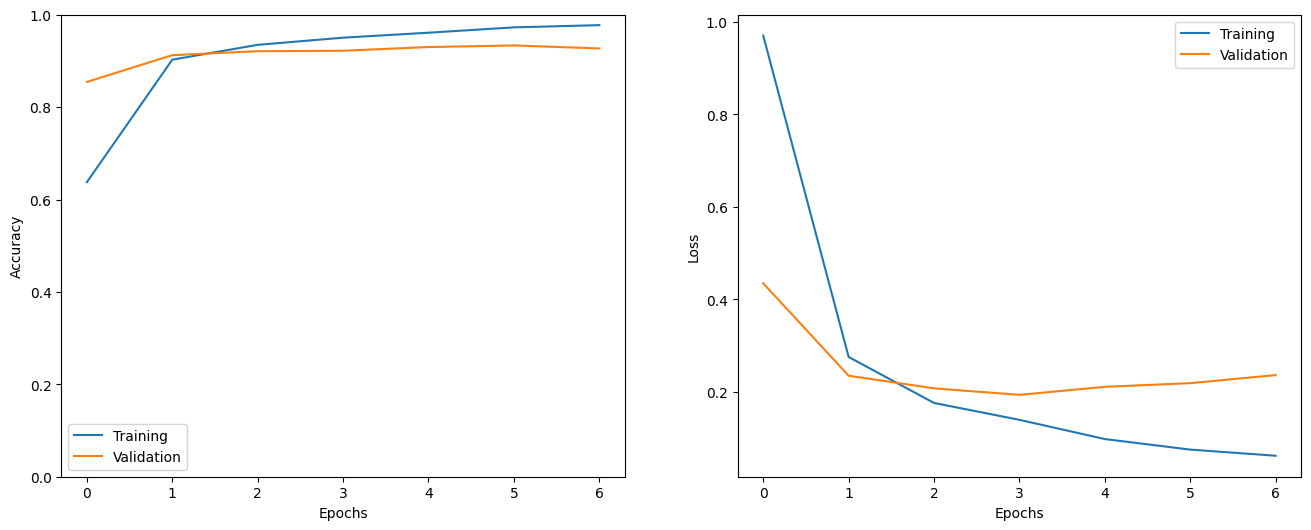

In [93]:
show_history(history)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


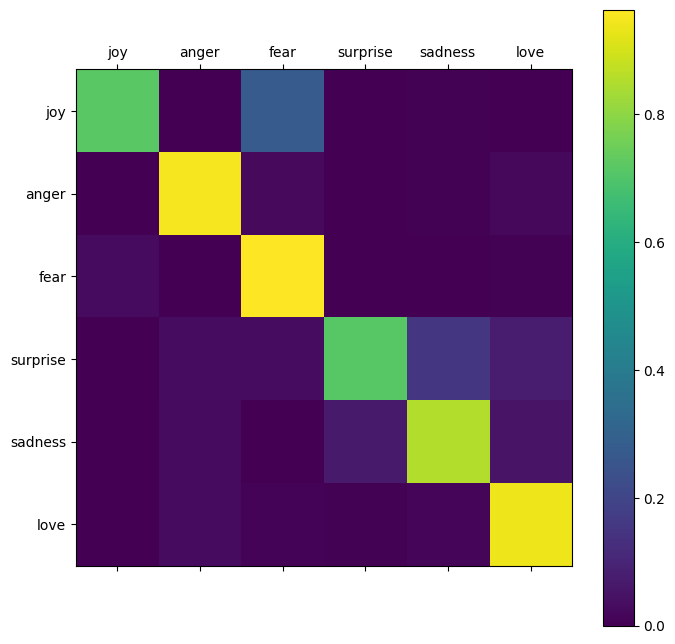

In [94]:
# Realizar predicciones
predictions = model.predict(test_sequences)
pred_classes = [index_to_classes[np.argmax(p)] for p in predictions]

show_confusion_matrix(test_labels, [classes_to_index[label] for label in pred_classes], list(classes_to_index.keys()))

In [95]:
_ = model.evaluate(test_sequences, test_labels)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9184 - loss: 0.1990


In [104]:
i = random.randint(0, len(test_labels) - 1)
print(f"Tweet: {test_tweets[i]}")
print(f"Emotion: {index_to_classes[test_labels[i]]}")

p = model.predict(np.expand_dims(test_sequences[i], axis=0))[0]
pred_class = index_to_classes[np.argmax(p).astype('uint8')]
print(f"Predicted Emotion: {pred_class}")

Tweet: im lucky enough in life to meet someone who makes me feel safe happy secure and loved i feel theres no reason to wait
Emotion: fear
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted Emotion: fear
